In [ ]:
! pip install torch diffusers transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [32]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import cv2

In [ ]:
class AvatarGenerator:
    def __init__(self):
        self.pipe = StableDiffusionPipeline.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            torch_dtype=torch.float16,
            safety_checker=None  
        ).to("cuda")
        
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        
        self.face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    def generate_with_controlled_noise(self, prompt, noise_scale=0.1):
        """Novel method: Inject controlled noise during generation"""
        enhanced_prompt = f"high-quality cartoon avatar of {prompt}, digital art, vibrant colors, symmetrical face, studio lighting"
        
        images = self.pipe(
            enhanced_prompt,
            negative_prompt="photo, realistic, 3d render, deformed",
            guidance_scale=7.5,
            num_inference_steps=30,
            generator=torch.Generator(device="cuda").manual_seed(42),
            noise_offset=noise_scale * torch.randn((1, 4, 64, 64), device="cuda")
        ).images
        
        return images[0]  
    def evaluate_avatar(self, image, prompt):
        """Novel evaluation metrics for avatars"""
        inputs = self.clip_processor(
            text=[prompt], 
            images=[image], 
            return_tensors="pt", 
            padding=True
        ).to("cuda")
        clip_score = self.clip_model(**inputs).logits_per_image.item()
        
        gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, 1.1, 4)
        face_score = len(faces) > 0
        
        return {
            "clip_score": clip_score,
            "face_detected": face_score,
            "symmetry": self._calculate_symmetry(image)  
        }
    
    def _calculate_symmetry(self, image):
        """Our novel symmetry metric for avatars"""
        img_array = np.array(image)
        mid = img_array.shape[1] // 2
        left = img_array[:, :mid]
        right = np.fliplr(img_array[:, -mid:])
        return np.mean(np.abs(left - right))  


In [ ]:
generator = AvatarGenerator()

In [48]:
prompts = [
    "A 1980s rockstar with wild hair and sunglasses."
]

Generating: A 1980s rockstar with wild hair and sunglasses.


  0%|          | 0/30 [00:00<?, ?it/s]

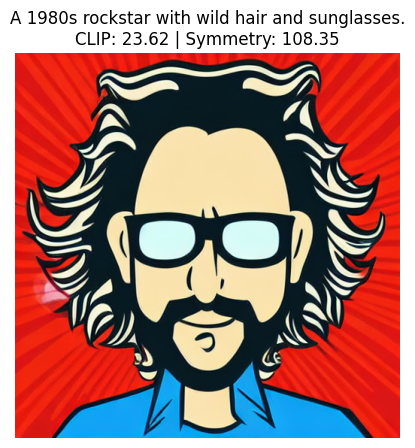


Research Results Summary:
A 1980s rockstar with wild hai | CLIP: 23.62 | Face: True | Symmetry: 108.35


In [49]:
results = []
for prompt in prompts:
    print(f"Generating: {prompt}")
    avatar = generator.generate_with_controlled_noise(prompt, noise_scale=0.15)
    metrics = generator.evaluate_avatar(avatar, prompt)
    results.append((prompt, avatar, metrics))
    
    plt.figure(figsize=(8,5))
    plt.imshow(avatar)
    plt.title(f"{prompt}\nCLIP: {metrics['clip_score']:.2f} | Symmetry: {metrics['symmetry']:.2f}")
    plt.axis('off')
    plt.show()

print("\nResearch Results Summary:")
for prompt, _, metrics in results:
    print(f"{prompt[:30]:<30} | CLIP: {metrics['clip_score']:.2f} | Face: {metrics['face_detected']} | Symmetry: {metrics['symmetry']:.2f}")